In [1]:
import sys
sys.path.insert(0, '/home/jonathan/Documents/mi3-gs/build/python')
sys.path.append("..")

import drjit as dr
import mitsuba as mi
from drjit.auto import Float, UInt, Bool
mi.set_variant('cuda_ad_rgb')

%load_ext autoreload
%autoreload 2

jit_find_library(): Unable to load "/usr/lib/llvm-15/lib/libLLVM.so": /home/jonathan/miniconda3/envs/volprim/lib/python3.11/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /usr/lib/llvm-15/lib/libLLVM.so)!


In [2]:
import volprim
from volprim.integrators.common import *

In [3]:
from scripts.radiosity.radiance_cache import RadianceCache
from scripts.radiosity.surface_sampler import SceneSurfaceSampler
from scripts.radiosity.vertex_bsdf import Diffuse

# scene_path = "/home/jonathan/Documents/volprim-balance/scenes/mitsuba/classroom/scene_indoor-lit.xml"
# scene = mi.load_file(scene_path)
# gs_path = "/home/jonathan/Documents/gaussian-splatting/output/mitsuba-classroom-lowlit/point_cloud/iteration_30000/point_cloud.ply"
# # gs_path = "/home/jonathan/Documents/gaussian-splatting/output/mitsuba-classroom-64spp_dn/point_cloud/iteration_30000/point_cloud.ply"
# # gs_path = "/home/jonathan/Documents/PGSR/output_mitsuba/classroom_spp=64_dn/test/point_cloud/iteration_30000/point_cloud.ply"


scene_path = "/home/jonathan/Documents/volprim-balance/scenes/mitsuba/classroom/scene_refine.xml"
scene = mi.load_file(scene_path)
gs_path = "/home/jonathan/Documents/gaussian-splatting-exr/output/classroom/point_cloud/iteration_30000/point_cloud.ply"

# scene = mi.load_dict(mi.cornell_box())
# gs_path = "/home/jonathan/Documents/gaussian-splatting-exr/output/cbox_logloss/point_cloud/iteration_30000/point_cloud.ply"


radiance_cache = RadianceCache(scene, gs_path)
scene_sampler = SceneSurfaceSampler(scene)
bsdf_train = Diffuse()

In [4]:
# from scripts.radiosity.visualizer import visualize_ellipsoids

# visualize_ellipsoids(radiance_cache.gs_scene)

In [5]:
# sampler = mi.load_dict({'type':'independent'})

# N = 512
# rng_state = 5
# si, rng_state = scene_sampler.sample(N, sampler, rng_state)
# sampler.seed(rng_state + 0x00FF_FFFF, N)
# d_local, weight, pdf_angle = radiance_cache.energy_pmf.sample(si, sampler.next_1d(), sampler.next_2d())
# print(d_local)
# print(weight)
# print(pdf_angle)

In [6]:
# # possible GS emitter sampling approach: treat them like meshes

# from scripts.radiosity.bsdf_utils import render_attributes, render_attributes_gt, ps_visualize_textures

# mesh: mi.Shape = radiance_cache.gs_scene.shapes()[0]
# sampler: mi.Sampler = mi.load_dict({'type': 'independent'})
# sampler.seed(0, 1 << 14)
# uv = sampler.next_2d()
# psi = mesh.sample_position(0.0, uv)

# import polyscope as ps

# ps.init()
# ps_visualize_textures(scene, False)
# points = ps.register_point_cloud("A", psi.p.numpy().T)
# points.add_vector_quantity("AA", psi.n.numpy().T)
# ps.show()

In [7]:
# from scripts.radiosity.bsdf_utils import ps_visualize_textures
# import polyscope as ps

# shapes = radiance_cache.gs_scene.shapes_dr()
# mesh: mi.Shape = dr.gather(mi.ShapePtr, shapes, dr.compress(shapes.shape_type() == UInt(mi.ShapeType.Ellipsoids)))
# sampler: mi.Sampler = mi.load_dict({'type': 'independent'})
# N = 1 << 14
# sampler.seed(0, N)
# psi = mesh.sample_position(0.0, sampler.next_2d())
# # psi = scene_sampler.sample(N, sampler)[0]

# ps.init()
# ps_visualize_textures(scene, False)
# points = ps.register_point_cloud("A", psi.p.numpy().T)
# points.add_vector_quantity("AA", psi.n.numpy().T)
# ps.show()

### Initialization

In [8]:
for mesh_idx, mesh in enumerate(scene.shapes()):
    if not(mesh.shape_type() == mi.ShapeType.Mesh):
        continue
    bsdf_train.initialize_mesh_attributes(mesh, [0.5, 0.5, 0.5])

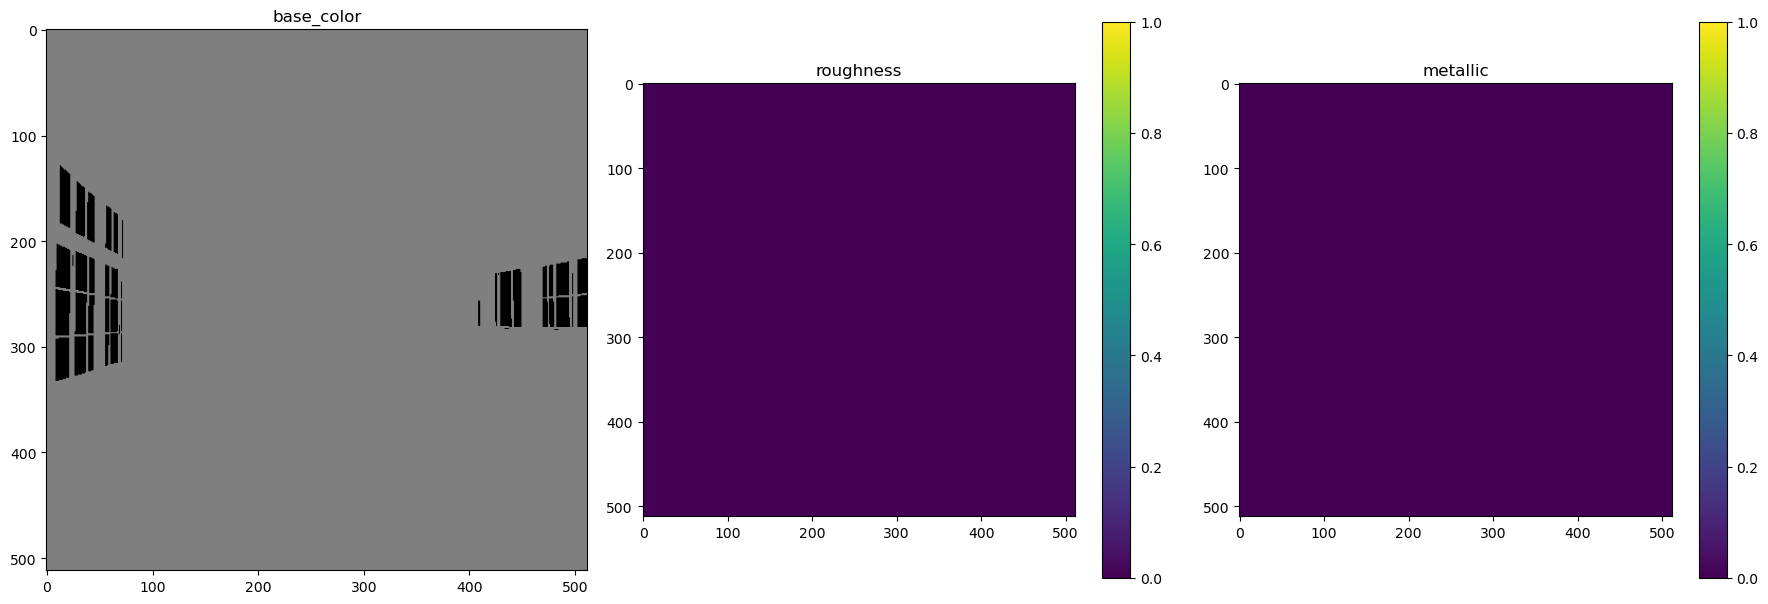

In [9]:
from scripts.radiosity.bsdf_utils import render_attributes, render_attributes_gt, ps_visualize_textures
import matplotlib.pyplot as plt

# ps_visualize_textures(scene)

# # 0
# up = mi.ScalarPoint3f(0,1,0)
# origin = mi.ScalarPoint3f(0,0.8,1)
# target = mi.ScalarPoint3f(0,0,0)

# # # 1
# # up = mi.ScalarPoint3f(0,1,0)
# # origin = mi.ScalarPoint3f(0,0.6,1)
# # target = mi.ScalarPoint3f(0,1,0)

# # # 2
# # up = mi.ScalarPoint3f(0,1,0)
# # origin = mi.ScalarPoint3f(-0.8,0.6,0.6)
# # target = mi.ScalarPoint3f(1,0,0)


# sensor = mi.load_dict({
#     'type': 'perspective',
#     'fov': 60,
#     'to_world': mi.ScalarTransform4f().look_at(origin, target, up)
#     })

# # Scene render
# plt.figure(figsize=(6,6), dpi=100)
# plt.imshow(mi.render(scene, sensor=sensor) ** (1.0 / 2.2)); plt.tight_layout()


# i = 0
# mi.util.write_bitmap(f"{i}_rt.exr", mi.render(scene, spp=256, sensor=sensor))
# mi.util.write_bitmap(f"{i}_gs.exr", mi.render(radiance_cache.gs_scene, spp=256, integrator=radiance_cache.integrator, sensor=sensor))

# BSDF initial values
plt.figure(figsize=(18,6), dpi=100)
out = render_attributes(scene, (512, 512), False)
plt.subplot(131); plt.imshow(out[:,:,:3]); plt.title("base_color")
plt.subplot(132); plt.imshow(out[:,:,3], vmin=0.0, vmax=1.0); plt.title("roughness"); plt.colorbar()
plt.subplot(133); plt.imshow(out[:,:,4], vmin=0.0, vmax=1.0); plt.title("metallic");  plt.colorbar()
# plt.subplot(133); plt.imshow(out[:,:,5], vmin=0.0, vmax=1.0); plt.title("anisotropic");  plt.colorbar()
# plt.subplot(133); plt.imshow(out[:,:,6], vmin=0.0, vmax=1.0); plt.title("spec_tint");  plt.colorbar()
plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..5.042428].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..262.08585].


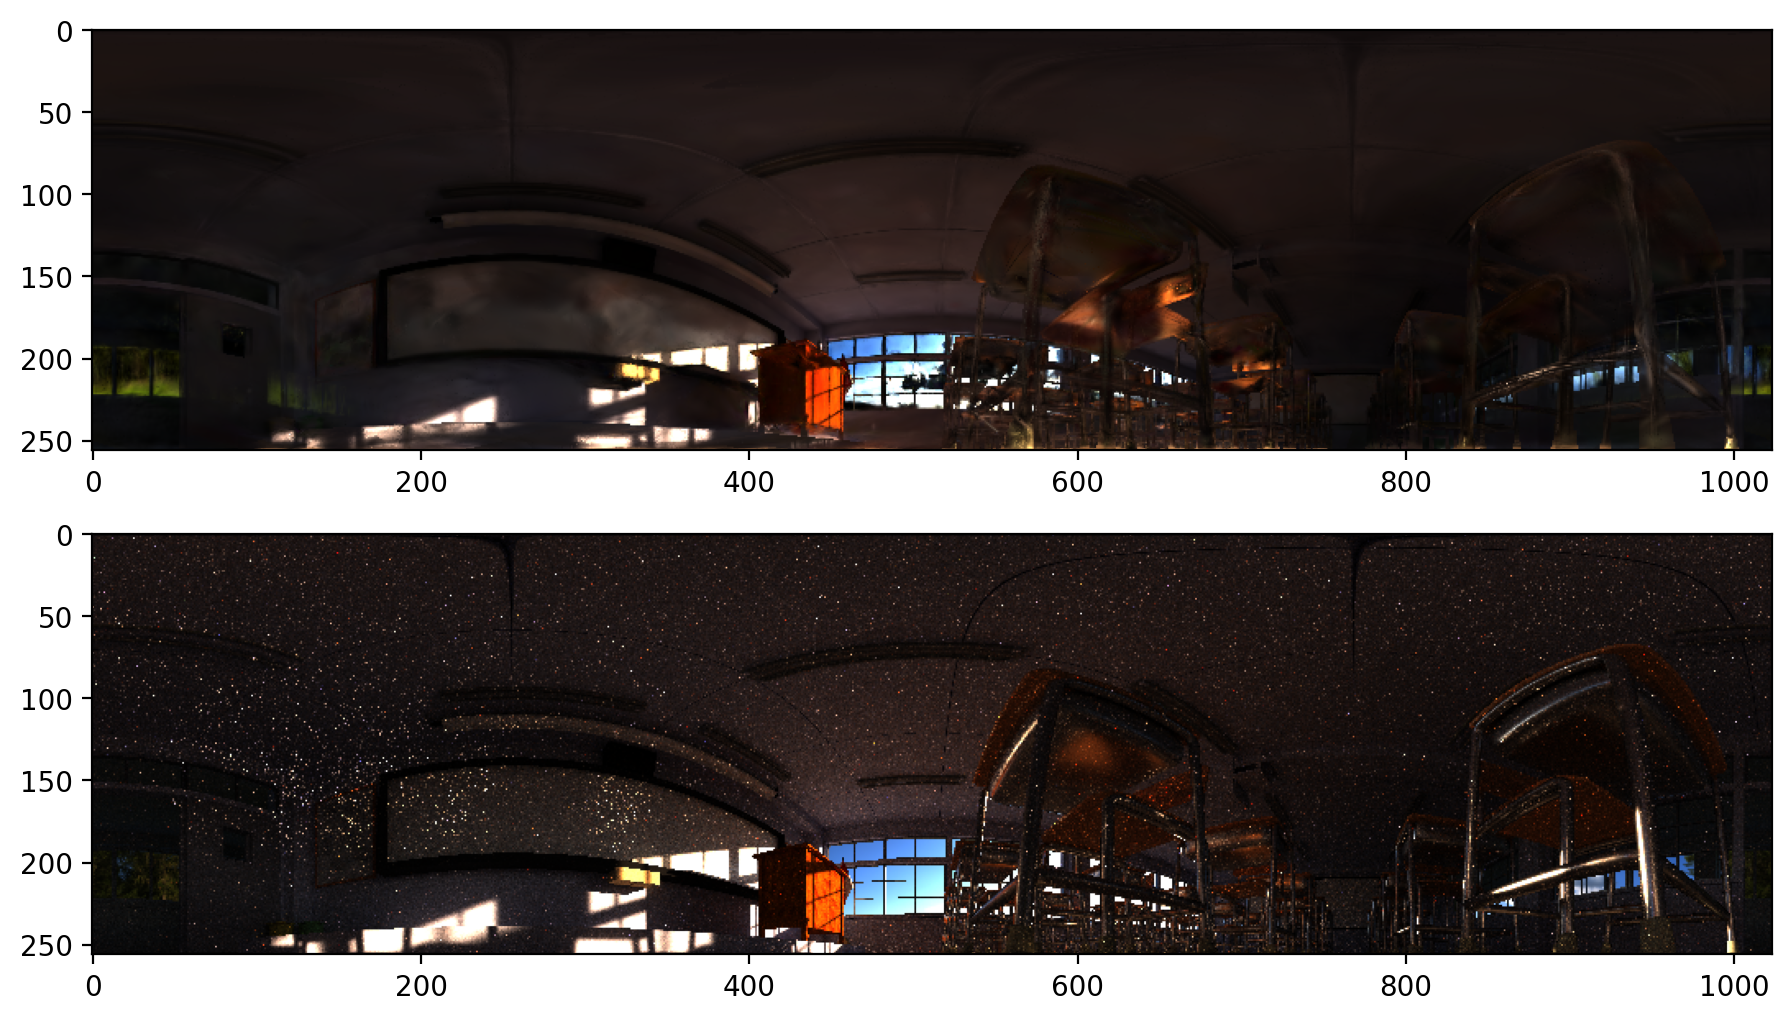

In [10]:
import polyscope as ps
from scripts.radiosity.radiance_cache import render_hemisphere_rt

sampler = mi.load_dict({'type': 'independent'})
# seed = 10
seed = 14
si = scene_sampler.sample(1 << 0, sampler, rng_state=seed)[0]
si_wide = dr.gather(type(si), si, dr.zeros(UInt, 256))
wi_rays = radiance_cache.eval_Li_mat(si_wide, sampler)[4]
wo_rays = radiance_cache.eval_Lo(si, sampler)[3]


N = 256
plt.figure(figsize=(13,6), dpi=200)
plt.subplot(211)
img_out, rays = radiance_cache._render_hemisphere(si, sampler, N, offset = 0.2)
img_out, rays = radiance_cache._render_hemisphere_auto_offset(si, sampler, N)
plt.imshow(img_out)
mi.util.write_bitmap("fisheye_gs.exr", mi.Bitmap(img_out))

plt.subplot(212)
img_out_, rays = render_hemisphere_rt(scene, si, sampler, N, spp = 256)
plt.imshow(img_out_)
mi.util.write_bitmap("fisheye_rt.exr", mi.Bitmap(img_out_))

# ps.init()
# ps_visualize_textures(scene, False)
# wi = ps.register_point_cloud("si", wi_rays.o.numpy().T)
# wi.add_vector_quantity("d", wi_rays.d.numpy().T)
# wo = ps.register_point_cloud("Lo", wo_rays.o.numpy().T)
# wo.add_vector_quantity("d", wo_rays.d.numpy().T)

# # tmp = ps.register_point_cloud("Lo", rays.o.numpy().T)
# # tmp.add_vector_quantity("d", rays.d.numpy().T)

# ps.show()

In [11]:
NUM_GEO_SAMPLES = 1 << 12 # 1 << 14
NUM_WI_DIRECTIONS = 256 << 0

In [20]:
from scripts.radiosity.radiance_cache import compute_loss
from scripts.radiosity.bsdf_utils import render_base_color
from time import time

params = mi.traverse(scene)
keys = [key for key in params.keys() if "vertex_bsdf_base_color" in key]
opt = mi.ad.Adam(lr=0.05)
for key in keys:
    dr.enable_grad(params[key])
    opt[key] = params[key]
    params.update(opt)

losses = []
for it in range(250):
    if it % 50 == 0:
        render_base_color(scene, (512, 512), True, f"output/itr={it}")

    time1 = time()

    # Evaluate the objective function for the current BSDF params
    loss = compute_loss(scene_sampler, radiance_cache, bsdf_train, 
        NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS, num_wo = 1, rng_state = it)
    
    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    # Post-process the optimized parameters to ensure legal color values.
    for key in keys:
        opt[key] = dr.clip(opt[key], 0.0, 1.0)

    # Update the scene state to the new optimized values
    params.update(opt)

    losses.append(loss.numpy())
    time2 = time()
    print(f"Iteration {1+it:03d} [{time2 - time1:2f}]: Loss = {loss}")

Iteration 001 [9.955325]: Loss = [0.0873637]
Iteration 002 [9.859848]: Loss = [0.0708254]
Iteration 003 [9.897773]: Loss = [0.0681427]
Iteration 004 [9.963039]: Loss = [0.0697226]
Iteration 005 [9.615562]: Loss = [0.0709912]
Iteration 006 [9.425162]: Loss = [0.0600075]
Iteration 007 [9.561423]: Loss = [0.0691685]
Iteration 008 [9.228536]: Loss = [0.0705551]
Iteration 009 [9.263812]: Loss = [0.0548268]
Iteration 010 [9.403913]: Loss = [0.0617236]
Iteration 011 [9.303763]: Loss = [0.0672906]
Iteration 012 [9.128531]: Loss = [0.0623909]
Iteration 013 [9.311530]: Loss = [0.0577927]
Iteration 014 [9.210066]: Loss = [0.057544]
Iteration 015 [9.224634]: Loss = [0.0697823]
Iteration 016 [9.247071]: Loss = [0.0612761]
Iteration 017 [9.463483]: Loss = [0.0551613]
Iteration 018 [9.933383]: Loss = [0.0515822]
Iteration 019 [9.956619]: Loss = [0.0640975]
Iteration 020 [9.809399]: Loss = [0.0546481]
Iteration 021 [9.788653]: Loss = [0.066794]
Iteration 022 [9.073998]: Loss = [0.0617562]
Iteration 02

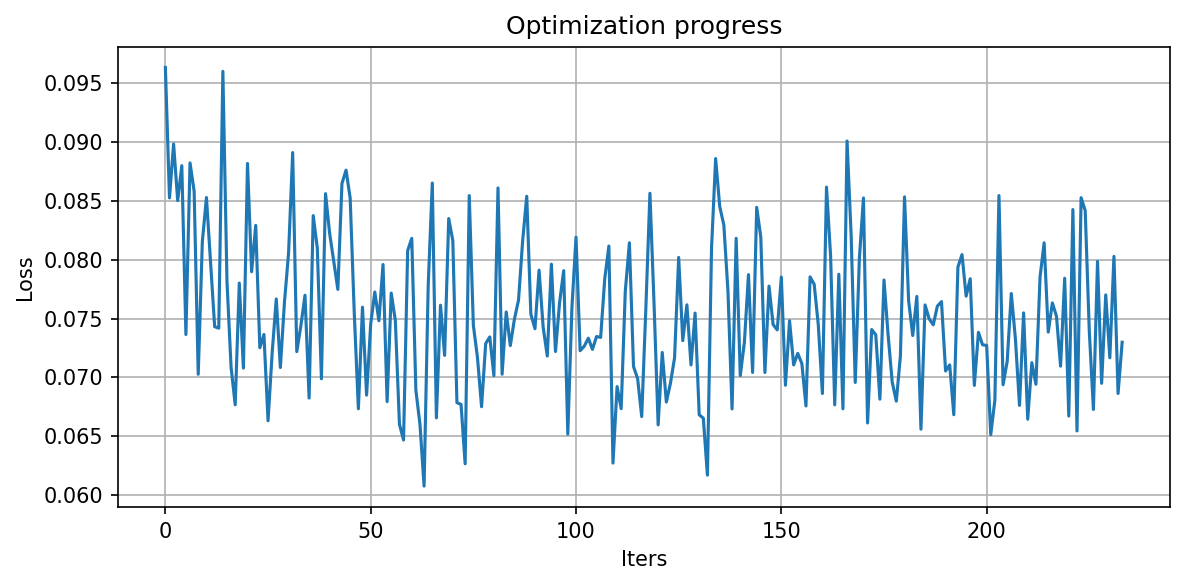

In [21]:
import numpy as np

plt.figure(figsize=(8,4), dpi=150)
plt.title("Optimization progress")
plt.plot(np.array(losses))
plt.xlabel("Iters")
plt.ylabel("Loss")
plt.grid()
plt.tight_layout()
# plt.savefig("./output/loss.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..17.412409].


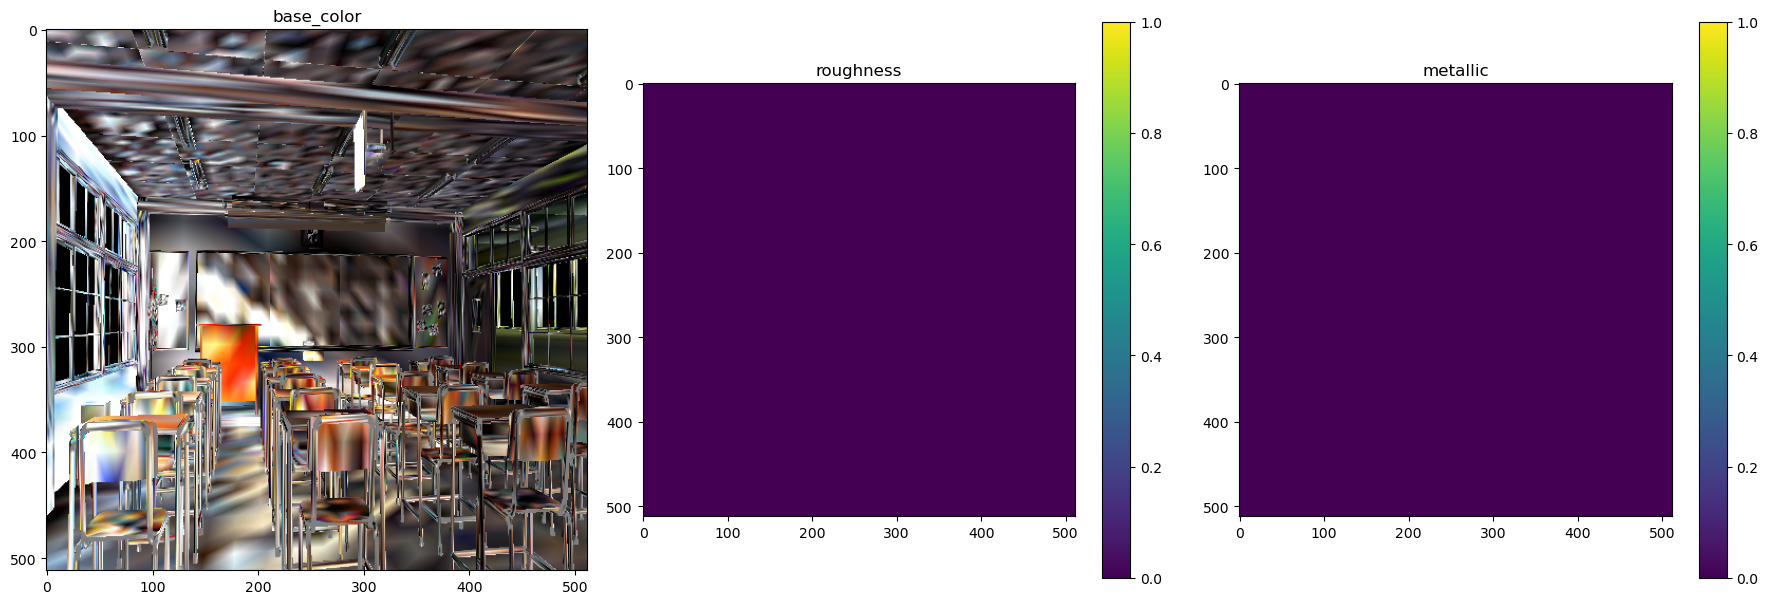

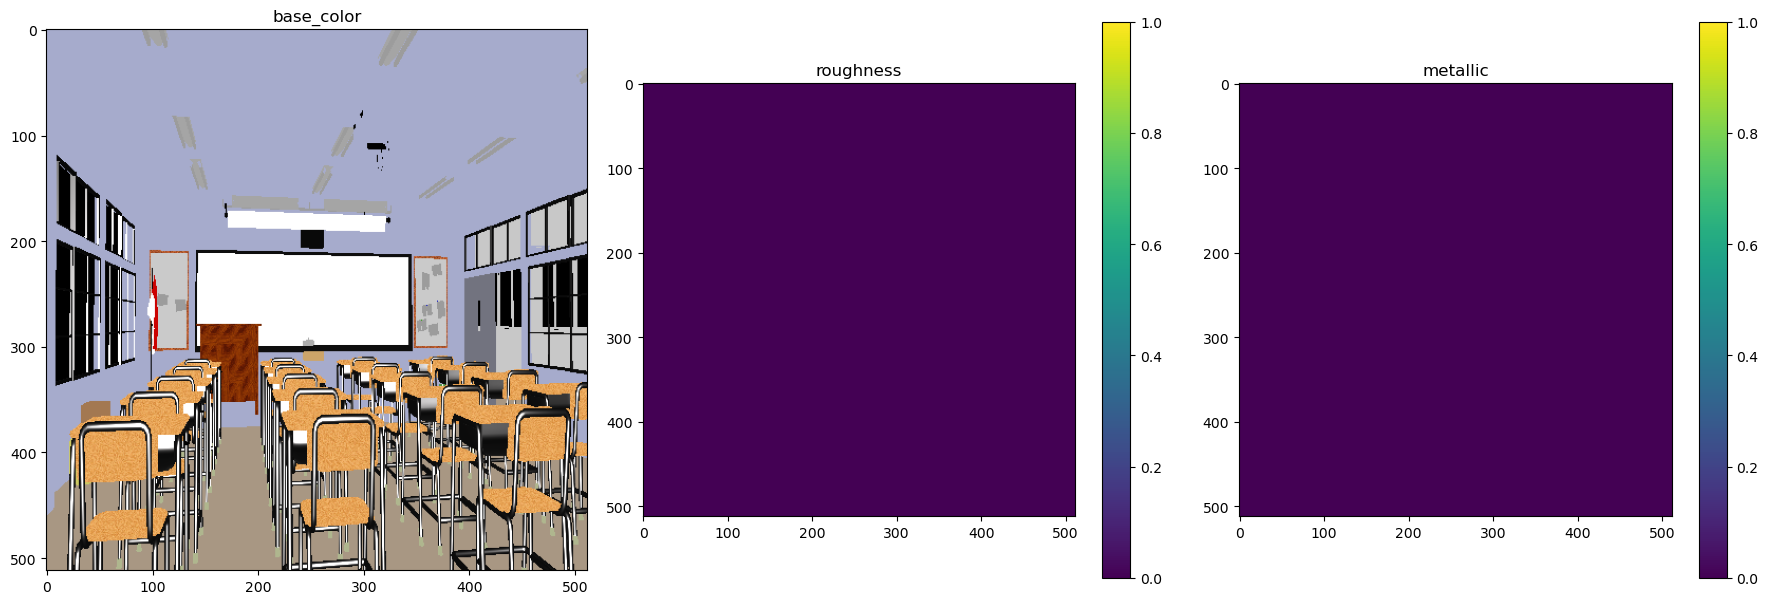

In [21]:
from scripts.radiosity.bsdf_utils import render_attributes, render_attributes_gt

out = render_attributes(scene, (512,512), True, "output/final")
# BSDF final values
plt.figure(figsize=(18,6), dpi=100)
plt.subplot(131); plt.imshow(out[:,:,:3]); plt.title("base_color")
plt.subplot(132); plt.imshow(out[:,:,3], vmin=0.0, vmax=1.0); plt.title("roughness"); plt.colorbar()
plt.subplot(133); plt.imshow(out[:,:,4], vmin=0.0, vmax=1.0); plt.title("metallic");  plt.colorbar()
# plt.subplot(133); plt.imshow(out[:,:,5], vmin=0.0, vmax=1.0); plt.title("anisotropic");  plt.colorbar()
# plt.subplot(133); plt.imshow(out[:,:,6], vmin=0.0, vmax=1.0); plt.title("spec_tint");  plt.colorbar()
plt.tight_layout()

out_gt = render_attributes_gt(scene, (512,512), True, "output/reference")

# BSDF final values
plt.figure(figsize=(18,6), dpi=100)
plt.subplot(131); plt.imshow(out_gt[:,:,:3]); plt.title("base_color")
plt.subplot(132); plt.imshow(out_gt[:,:,3], vmin=0.0, vmax=1.0); plt.title("roughness"); plt.colorbar()
plt.subplot(133); plt.imshow(out_gt[:,:,4], vmin=0.0, vmax=1.0); plt.title("metallic");  plt.colorbar()
# plt.subplot(133); plt.imshow(out_gt[:,:,5], vmin=0.0, vmax=1.0); plt.title("anisotropic");  plt.colorbar()
# plt.subplot(133); plt.imshow(out_gt[:,:,6], vmin=0.0, vmax=1.0); plt.title("spec_tint");  plt.colorbar()
plt.tight_layout()



In [22]:
ps_visualize_textures(scene)



[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 3.3.0 NVIDIA 550.120
